# Install necessary packages

In [ ]:
# !pip install top2vec
# !pip install pyLDAvis
!pip install bertopic
!python -m spacy download en_core_web_lg

# Read the transcripts

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
df = pd.read_pickle("/content/drive/MyDrive/transcript_texts.pkl")
df.head()

,Company,Call,Date_of_call,Type_of_text,Person,Text,Order,Industry
0,Abbott Laboratories,"Abbott Laboratories, Q1 2018 Earnings Call, Ap...",2018-04-18,Presentation Operator Message,Operator,Good morning and thank you for standing by. We...,0,Healthcare
1,Abbott Laboratories,"Abbott Laboratories, Q1 2018 Earnings Call, Ap...",2018-04-18,Presenter Speech,Scott Leinenweber,Good morning and thank you for joining us. \r\...,1,Healthcare
2,Abbott Laboratories,"Abbott Laboratories, Q1 2018 Earnings Call, Ap...",2018-04-18,Presenter Speech,Miles White,"Okay. Thanks, Scott, and good morning. \r\nTod...",2,Healthcare
3,Abbott Laboratories,"Abbott Laboratories, Q1 2018 Earnings Call, Ap...",2018-04-18,Presenter Speech,Brian Yoor,"Okay. Thanks, Miles. \r\nAnd as Scott mentione...",3,Healthcare
4,Abbott Laboratories,"Abbott Laboratories, Q1 2018 Earnings Call, Ap...",2018-04-18,Question and Answer Operator Message,Operator,[Operator Instructions] And our first question...,4,Healthcare


In [3]:
df = df[df['Date_of_call'] >= '2021-01-01']

In [ ]:
df.Industry.unique()

array(['Healthcare', 'Semiconductor', 'Transportation', 'Financial',
       'Technology', 'Industrial', 'Oil and Gas', 'Consumer'],
      dtype=object)

In [ ]:
df['Type_of_text'].unique()

array(['Presentation Operator Message', 'Presenter Speech',
       'Question and Answer Operator Message', 'Question', 'Answer'],
      dtype=object)

In [4]:
df2 = df.groupby('Call')['Text'].apply(lambda x: ' '.join(x)).to_frame(name='Text')
df2.head(5)

,Text
Call,
"Abbott Laboratories, Q1 2021 Earnings Call, Apr 20, 2021","Good morning, and thank you for standing by. W..."
"Abbott Laboratories, Q1 2022 Earnings Call, Apr 20, 2022","Good morning, and thank you for standing by. W..."
"Abbott Laboratories, Q2 2021 Earnings Call, Jul 22, 2021","Good morning, and thank you for standing by. W..."
"Abbott Laboratories, Q3 2021 Earnings Call, Oct 20, 2021","Good morning, and thank you for standing by. W..."
"Abbott Laboratories, Q4 2020 Earnings Call, Jan 27, 2021","Good morning, and thank you for standing by. W..."


# Pre-processing

In [25]:
import re
# df2['Text'] = df2['Text'].map(lambda x: re.sub('[\n\t\r.,;\'\"\[\]]*', '',x))

# Convert to lowercase
df2['Text'] = df2['Text'].map(lambda x: x.lower())

In [26]:
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df2.Text.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['good', 'morning', 'and', 'thank', 'you', 'for', 'standing', 'by', 'welcome', 'to', 'abbott', 'first', 'quarter', 'earnings', 'conference', 'call', 'operator', 'instructions', 'this', 'call', 'is', 'being', 'recorded', 'by', 'abbott', 'with', 'the', 'exception', 'of', 'any']


In [7]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [27]:
#NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'ie', 'st', 'th', 'rd','quarter','year','month','us','well','would',
                   'think','question', 'billion', 'million', 'thousands','recorded','morning','new','weve',
                   'thats', 'revenue', 'income','company','quarter','year','month','earnings','call','transcript',
                   'new', 'business', 'results','report','statement','today','said','like','going','think','question','answer',
                   'ask', 'know', 'well', 'would', 'could', 'may', 'great',
                   'might', 'get', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',
                   'eight', 'nine', 'ten', 'zero', 'thousand', 'percent', 'percentage',
                   'point', 'points', 'market', 'stock', 'price', 'share', 'analyst',
                   'investor', 'conference', 'operator', 'good', 'morning', 'afternoon',
                   'evening', 'thank', 'operator', 'forward', 'looking', 'statements',
                   'information', 'future', 'events', 'circumstances', 'risks',
                   'uncertainties', 'assumptions', 'factors', 'developments', 'events',
                   'performance', 'results', 'forward', 'risks', 'statements',
                   'events', 'developments','business','first','see','continue','strong','last','also',
                   'going','really',' thats','next','get','back','thats','kind','content', 'product', 'lot',
                   'expect','like','obviously','yes','time','right','years','look','im','look','bit','second',
                   'little','across','capital','youre','still','got','go', 'say', 'talk', 'take', 'come', 'make'])


# Define functions for stopwords, bigram, trigrams, lemmatization
def remove_stopwords(texts):
    return[[word for word in simple_preprocess(str(doc)) \
            if word not in stop_words] for doc in texts]

# def make_bigrams(texts):
    # return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc \
                          if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# x = lemmatization(data_words)

In [28]:
data_words_nostops = remove_stopwords(data_words)

# LDA

In [ ]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(data_lemmatized)

# # Create Corpus
# texts = data_lemmatized

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

# # view check
# print(corpus[:1])

In [ ]:
# from gensim import matutils, models, utils
# # Build LDA model
# lda_model = models.LdaMulticore(corpus=corpus,
#                                       id2word=id2word,
#                                       num_topics=10,
#                                       random_state=100,
#                                       chunksize=100,
#                                       passes=10,
#                                       per_word_topics=True)

In [ ]:
# # top 20 significant terms and their probabilities for each topic
# topics=[]
# for i in range(0,10):
#     topic_list=[]
#     for term, wt in lda_model.show_topic(i, topn=20):
#         topic_list.append((term, round(wt,3)))
#     topics.append(topic_list)

In [ ]:
# lda_topics = pd.DataFrame()
# for i,topic in enumerate(topics):
#   lda_topics["Topic_"+str(i)] = pd.Series([x[0] for x in topic])

# lda_topics.head()



In [ ]:
# lda_topics.to_excel("LDA_output.xlsx")

## Visualization

In [ ]:
import pyLDAvis.gensim_models
import pyLDAvis

#visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

pyLDAvis.display(LDAvis_prepared)

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## Evaluation

In [ ]:
# Compute Model Perplexity and coherence score
from gensim.models import CoherenceModel

#Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized,
                                    dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3355453170593397


# BERTopic



In [29]:
flatten_data = [' '.join(sub) for sub in data_words_nostops]
flatten_data[0]

'standing welcome abbott instructions abbott exception participants questions asked session entire including session material copyrighted abbott cannot rebroadcast without abbott express written permission introduce mr scott leinenweber vice president relations licensing acquisitions joining robert ford president chief executive officer bob funck executive vice president finance chief financial officer robert bob provide opening remarks following comments questions started made purposes private securities litigation reform act including expected financial abbott cautions cause actual differ materially indicated economic competitive governmental technological affect abbott operations discussed item risk annual form ended december abbott undertakes obligation release publicly revisions result subsequent development except required law please note financial provided sales eps line items continuing operations past non gaap financial measures used help investors understand abbott ongoing no

In [ ]:
# !pip install --upgrade joblib==1.1.0 # Little trick to downgrade your joblib while import BERTopic in Colab else it will throw joblib metadata error

In [32]:
from bertopic import BERTopic
model = BERTopic(verbose=True, min_topic_size= 10,nr_topics=7)
topics, _ = model.fit_transform(flatten_data)

2024-03-18 12:50:29,937 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-03-18 12:51:31,467 - BERTopic - Embedding - Completed ✓
2024-03-18 12:51:31,470 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-18 12:51:35,752 - BERTopic - Dimensionality - Completed ✓
2024-03-18 12:51:35,755 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-18 12:51:35,773 - BERTopic - Cluster - Completed ✓
2024-03-18 12:51:35,776 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-18 12:51:37,435 - BERTopic - Representation - Completed ✓
2024-03-18 12:51:37,437 - BERTopic - Topic reduction - Reducing number of topics
2024-03-18 12:51:39,109 - BERTopic - Topic reduction - Reduced number of topics from 11 to 7


In [12]:
top_words = model.get_topic(1)
print(top_words)

[('go', 0.03569540836799916), ('cash', 0.028203463346111384), ('make', 0.024315127221620738), ('asset', 0.02425779212279445), ('low', 0.02286232284859017), ('debt', 0.021782472085567908), ('cost', 0.021338707804729885), ('say', 0.021100480878370097), ('project', 0.02092706584512893), ('high', 0.020807306082672023)]


In [34]:
model.save("/content/drive/MyDrive/model_min_topic_size_10_nr_topics_7")

2024-03-18 12:54:25,491 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
model.save('/content/drive/MyDrive/BERTopic_model8')

2024-03-13 07:51:39,856 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [44]:
saved_model = BERTopic.load("/content/drive/MyDrive/model_min_topic_size_10_nr_topics_7")

## Visualization

In [33]:
model.visualize_barchart(n_words = 10,width = 300,height=300,top_n_topics=8)

In [37]:
model.visualize_heatmap()

In [ ]:
# model2.visualize_barchart(n_words = 10,width = 300,height=300,top_n_topics=5)

Saving the topics to save time while demo session

In [52]:
import numpy as np
np_topics = np.array(topics)

# Saving the topic array to local
# np.save("drive/MyDrive/topics_arr",np_topics)

# Loading the topic array from local
# topics = np.load("content/drive/MyDrive/topics_arr.npy")
topics = np_topics.tolist()

In [53]:
documents = pd.DataFrame({"Transcript": flatten_data,
                          "ID": range(len(flatten_data)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Transcript': ' '.join})
cleaned_docs = saved_model._preprocess_text(documents_per_topic.Transcript.values)

In [54]:
# Extract vectorizer and analyzer from BERTopic
vectorizer = saved_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

In [55]:
import gensim.corpora as corpora
# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in saved_model.get_topic(topic)]
               for topic in range(len(set(topics))-1)]

## Evaluation

In [56]:
from gensim.models.coherencemodel import CoherenceModel
# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')
coherence = coherence_model.get_coherence()

In [58]:
print(coherence)

0.571279689526497


# Top2Vec

In [ ]:
from top2vec import Top2Vec
model2 = Top2Vec(flatten_data,topic_merge_delta=0.6,hdbscan_args={'min_cluster_size':7},workers=8)

2023-03-20 16:28:58,025 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-03-20 16:29:05,043 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-03-20 16:39:24,780 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-03-20 16:39:27,601 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-03-20 16:39:27,621 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
model2.get_num_topics()

In [ ]:
model2.topic_words

Save the model to avoid re-training

In [ ]:
model2.save("Top2Vec_model")

Load the saved model

In [ ]:
from top2vec import Top2Vec
model = Top2Vec.load("drive/MyDrive/Top2Vec_model")

### Visualization

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import colorcet as cc
import random

sns.set_palette("bright")
palette = sns.color_palette(cc.glasbey, n_colors=25)

In [ ]:
color = ['tomato','lime','mediumblue','crimson','gold','aqua','chocolate','darkorange','purple','red']

In [ ]:
def show_bar_chart(topics_words,word_scores,no_of_words=5,no_of_topics=10):
  fig, axes = plt.subplots(2, 5,figsize=(25, 10))
  #plt.title("Topic word scores")
  row = 0
  column = 0
  for i in range(no_of_topics):
    #color = (np.random.random(), np.random.random(), np.random.random())
    sns.barplot(y = topics_words[i][:no_of_words],x = word_scores[i][:no_of_words],ax=axes[row,column],orient='h',color=color[i])
    if (column == 4):
      row += 1
      column = 0
    else:
      column += 1
  plt.show()


In [ ]:
topics_words, word_scores, topic_nums = model.get_topics(10)

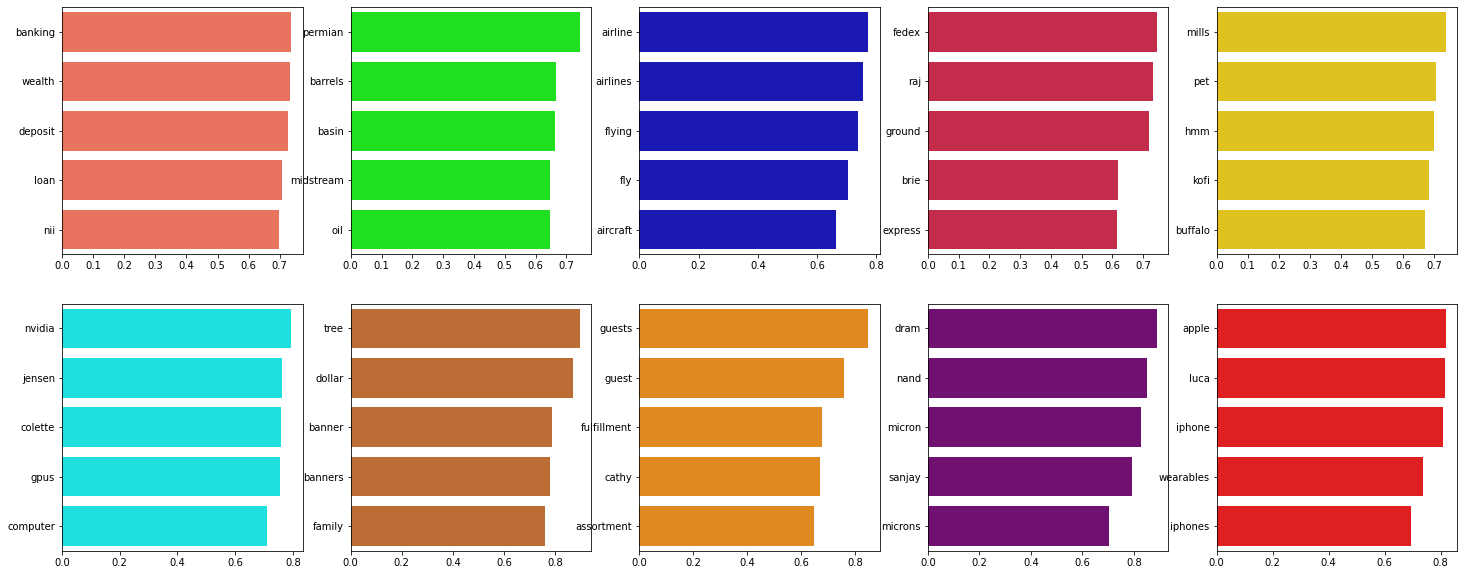

In [ ]:
show_bar_chart(topics_words,word_scores,no_of_words=5,no_of_topics=10)

### Exploring the model results

In [ ]:
doc_topics = model.doc_top

In [ ]:
len(doc_topics)

701

In [ ]:
df3 = df2.copy()
df3["Topic"] = pd.Series(doc_topics)
df3.head()

,Call,Text,Topic
0,"Abbott Laboratories, Q1 2018 Earnings Call, Ap...",good morning and thank you for joining us with...,13
1,"Abbott Laboratories, Q1 2019 Earnings Call, Ap...",good morning and thank you for joining us with...,13
2,"Abbott Laboratories, Q1 2020 Earnings Call, Ap...",good morning and thank you for joining us with...,13
3,"Abbott Laboratories, Q1 2021 Earnings Call, Ap...",good morning and thank you for joining us with...,13
4,"Abbott Laboratories, Q1 2022 Earnings Call, Ap...",good morning and thank you for joining us with...,13


In [ ]:
df3["Name"] = df3["Topic"].apply(lambda x: "Topic_" + str(x))
df3.head()

,Call,Text,Topic,Name
0,"Abbott Laboratories, Q1 2018 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13
1,"Abbott Laboratories, Q1 2019 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13
2,"Abbott Laboratories, Q1 2020 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13
3,"Abbott Laboratories, Q1 2021 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13
4,"Abbott Laboratories, Q1 2022 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13


In [ ]:
topic_words = model.topic_words
word_dict = {}
for i,words in enumerate(topic_words):
  word_dict[i] = '-'.join(words[:5])

word_dict


{0: 'banking-wealth-deposit-loan-nii',
 1: 'permian-barrels-basin-midstream-oil',
 2: 'airline-airlines-flying-fly-aircraft',
 3: 'fedex-raj-ground-brie-express',
 4: 'mills-pet-hmm-kofi-buffalo',
 5: 'nvidia-jensen-colette-gpus-computer',
 6: 'tree-dollar-banner-banners-family',
 7: 'guests-guest-fulfillment-cathy-assortment',
 8: 'dram-nand-micron-sanjay-microns',
 9: 'apple-luca-iphone-wearables-iphones',
 10: 'starbucks-roz-coffee-beverages-nestle',
 11: 'netflix-ted-reed-spence-films',
 12: 'albert-angela-mikael-pfizer-frank',
 13: 'abbott-libre-alinity-mitraclip-nutrition',
 14: 'restaurants-mcdonalds-restaurant-franchisees-menu',
 15: 'airplanes-airplane-bca-boeing-skyline',
 16: 'marc-thermo-bioproduction-biotech-biosciences',
 17: 'rafael-analog-millimeter-consignment-ti',
 18: 'ashley-medical-johnson-surgery-pharmaceutical',
 19: 'kellogg-pringles-snacks-cereal-foods',
 20: 'lisa-amd-epyc-devinder-server',
 21: 'intel-dcg-nanometer-modem-intels',
 22: 'darius-honeywell-pmt-sp

In [ ]:
df3["Top_n_words"] = df3["Topic"].apply(lambda x: word_dict[x])
df3.head()

,Call,Text,Topic,Name,Top_n_words
0,"Abbott Laboratories, Q1 2018 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13,abbott-libre-alinity-mitraclip-nutrition
1,"Abbott Laboratories, Q1 2019 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13,abbott-libre-alinity-mitraclip-nutrition
2,"Abbott Laboratories, Q1 2020 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13,abbott-libre-alinity-mitraclip-nutrition
3,"Abbott Laboratories, Q1 2021 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13,abbott-libre-alinity-mitraclip-nutrition
4,"Abbott Laboratories, Q1 2022 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13,abbott-libre-alinity-mitraclip-nutrition


In [ ]:
df3.to_pickle("topic_modelling_results_v2.pkl")

In [ ]:
words_to_excel = pd.DataFrame()
for i,words in enumerate(topic_words):
  words_to_excel["Topic_" + str(i)] = pd.Series(words)
words_to_excel.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29,Topic_30,Topic_31
0,banking,permian,airline,fedex,mills,nvidia,tree,guests,dram,apple,...,darius,ge,holden,facebook,dealer,propositions,walmart,pharmacy,uber,carol
1,wealth,barrels,airlines,raj,pet,jensen,dollar,guest,nand,luca,...,honeywell,renewables,fastenal,instagram,dealers,sme,ecommerce,stefano,dara,smb
2,deposit,basin,flying,ground,hmm,colette,banner,fulfillment,micron,iphone,...,pmt,healthcare,vending,sheryl,caterpillar,card,brett,walgreens,eats,surcharges
3,loan,midstream,fly,brie,kofi,gpus,banners,cathy,sanjay,wearables,...,sps,larry,onsites,ads,jim,amex,sams,alex,nelson,smbs
4,nii,oil,aircraft,express,buffalo,computer,family,assortment,microns,iphones,...,intelligrated,aviation,onsite,advertisers,mining,billed,omni,boots,rides,ups


In [ ]:
words_to_excel.to_excel("topic_words.xlsx")

In [ ]:
df2[df2.Call.apply(lambda x: x.split(",")[0].startswith('Apple'))]

,Call,Text
68,"Apple Inc., Q1 2018 Earnings Call, Feb 01, 2018",thank you good afternoon and thanks to everyon...
69,"Apple Inc., Q1 2019 Earnings Call, Jan 29, 2019",thank you good afternoon and thanks to everyon...
70,"Apple Inc., Q1 2020 Earnings Call, Jan 28, 2020",thank you good afternoon and thank you for joi...
71,"Apple Inc., Q1 2021 Earnings Call, Jan 27, 2021",thank you good afternoon and thank you for joi...
72,"Apple Inc., Q1 2022 Earnings Call, Jan 27, 2022",thank you good afternoon and thank you for joi...
73,"Apple Inc., Q2 2018 Earnings Call, May 01, 2018",audio gapand hell be followed by cfo luca maes...
74,"Apple Inc., Q2 2019 Earnings Call, Apr 30, 2019",thank you good afternoon and thanks to everyon...
75,"Apple Inc., Q2 2020 Earnings Call, Apr 30, 2020",thank you good afternoon and thank you for joi...
76,"Apple Inc., Q2 2021 Earnings Call, Apr 28, 2021",thank you good afternoon and thank you for joi...
77,"Apple Inc., Q2 2022 Earnings Call, Apr 28, 2022",thank you good afternoon and thank you for joi...


Airlines example of least probable hypothesis check

In [ ]:
df2[df2["Call"]=="American Airlines Group Inc., Q2 2020 Earnings Call, Jul 23, 2020"]

,Call,Text
41,"American Airlines Group Inc., Q2 2020 Earnings...",thanks sarah and good morning everyone and wel...


In [ ]:
df2.iloc[41]

Call    American Airlines Group Inc., Q2 2020 Earnings...
Text    thanks sarah and good morning everyone and wel...
Name: 41, dtype: object

Most dominant topic

In [ ]:
doc_topics[41]

2

Topic 2 words

In [ ]:
model.topic_words[2]

array(['airline', 'airlines', 'flying', 'fly', 'aircraft', 'derek',
       'flights', 'southwest', 'gerry', 'tammy', 'casm', 'leisure',
       'vasu', 'passengers', 'seats', 'rasm', 'flight', 'fleet', 'robert',
       'andrew', 'travel', 'schedule', 'grounding', 'seat', 'hawaii',
       'uniteds', 'max', 'asm', 'asms', 'tom', 'fares', 'united', 'hubs',
       'summer', 'boeing', 'travelers', 'mike', 'gary', 'mainline',
       'passenger', 'american', 'load', 'routes', 'booking', 'operation',
       'schedules', 'departure', 'attendants', 'airport', 'dfw'],
      dtype='<U15')

All topics discussed in the transcripts

In [ ]:
topic_nums,topic_score,topics_words,word_scores = model.get_documents_topics([41],num_topics=33)

In [ ]:
topic_nums

array([[ 2, 15, 22,  1,  0, 20, 21, 29, 27, 24, 30,  7, 23, 31, 16,  3,
        11, 10,  9, 12, 25, 26, 17, 28,  8, 19, 14, 18,  6,  5,  4, 13]])

Topic score with COVID as the term

In [ ]:
topic_words2, word_scores2, topic_scores2, topic_nums2 = model.search_topics(keywords=["covid"], num_topics=5)

In [ ]:
topic_nums2

array([18, 12, 16, 13, 29])

In [ ]:
topic_scores2

array([0.34367804, 0.26568945, 0.2394232 , 0.21826168, 0.1797369 ])

In [ ]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=18, num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 331, Score: 0.7421945333480835
-----------
good chris delorefice vice president investor relations johnson johnson welcome companys review business results third joining todays call joe wolk executive vice president chief financial officer additionally session joe pleased joined ashley mcavoy executive vice president worldwide chairman medical devices thibaut mongon executive vice president worldwide chairman consumer jennifer taubert executive vice president worldwide chairman pharmaceuticals logistics get details review made available via webcast accessible investor relations section johnson johnson website investorjnjcom also find additional materials including todays presentation associated schedulesplease note todays presentation includes forward looking statements encourage review cautionary statement regarding statements included todays presentation companys form identifies certain factors may cause companys actual results differ materially projected sec filings includ

In [ ]:
topic_score

array([[0.6494784 , 0.13284017, 0.12833051, 0.1262695 , 0.11789929],
       [0.69041306, 0.18522732, 0.15652812, 0.15303034, 0.14585689]],
      dtype=float32)

In [ ]:
model.get_num_topics()

32

In [ ]:
import numpy as np
topic_nums,topic_score,topics_words,word_scores = model.get_documents_topics(np.arange(701),num_topics=5)

In [ ]:
topic_nums = topic_nums.tolist()
topic_score = topic_score.tolist()
topics_words = topics_words.tolist()
word_scores = word_scores.tolist()

In [ ]:
df3["top_5_topics"] = pd.Series(topic_nums)
df3["top_5_topics_score"] = pd.Series(topic_score)
df3["top_5_topics_words"] = pd.Series(topics_words)
df3["top_5_word_scores"] = pd.Series(word_scores)
df3.head()

,Call,Text,Topic,Name,Top_n_words,top_5_topics,top_5_topics_score,top_5_topics_words,top_5_word_scores
0,"Abbott Laboratories, Q1 2018 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13,abbott-libre-alinity-mitraclip-nutrition,"[13, 12, 11, 18, 16]","[0.601823091506958, 0.13026341795921326, 0.129...","[[abbott, libre, alinity, mitraclip, nutrition...","[[0.7602687478065491, 0.7529654502868652, 0.69..."
1,"Abbott Laboratories, Q1 2019 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13,abbott-libre-alinity-mitraclip-nutrition,"[13, 18, 12, 9, 19]","[0.6743338108062744, 0.1959945559501648, 0.191...","[[abbott, libre, alinity, mitraclip, nutrition...","[[0.7602687478065491, 0.7529654502868652, 0.69..."
2,"Abbott Laboratories, Q1 2020 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13,abbott-libre-alinity-mitraclip-nutrition,"[13, 12, 18, 16, 19]","[0.5312502384185791, 0.16475310921669006, 0.15...","[[abbott, libre, alinity, mitraclip, nutrition...","[[0.7602687478065491, 0.7529654502868652, 0.69..."
3,"Abbott Laboratories, Q1 2021 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13,abbott-libre-alinity-mitraclip-nutrition,"[13, 16, 19, 18, 9]","[0.6785067319869995, 0.21797850728034973, 0.17...","[[abbott, libre, alinity, mitraclip, nutrition...","[[0.7602687478065491, 0.7529654502868652, 0.69..."
4,"Abbott Laboratories, Q1 2022 Earnings Call, Ap...",good morning and thank you for joining us with...,13,Topic_13,abbott-libre-alinity-mitraclip-nutrition,"[13, 18, 16, 12, 29]","[0.6344333291053772, 0.21608230471611023, 0.19...","[[abbott, libre, alinity, mitraclip, nutrition...","[[0.7602687478065491, 0.7529654502868652, 0.69..."


In [ ]:
df3.to_pickle("Top2Vec_5dominant_df.pkl")

### Evaluation

In [ ]:
import gensim.corpora as corpora
from gensim.utils import tokenize
from gensim.models import CoherenceModel
topic_words = model.topic_words
tokenized = [list(tokenize(s)) for s in flatten_data]
id2word = corpora.Dictionary(tokenized)
corpus = [id2word.doc2bow(text) for text in tokenized]

cm = CoherenceModel(topics=[s.tolist() for s in topic_words] ,texts=tokenized
                    , corpus=corpus, dictionary=id2word, coherence='c_v')

print("Model Coherence C_V is:{0}".format(cm.get_coherence()))

Model Coherence C_V is:0.865496888651982
